# **한국어 데이터로 챗봇 만들기**

In [1]:
import torch
print(torch.__version__)

2.10.0+cu128


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

## **Step 1. 데이터 수집하기**

In [3]:
# !mkdir -p ~/work/transformer_chatbot/data/ && cd ~/work/transformer_chatbot/data/
# !wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv

## **Step 2. 데이터 전처리하기**

In [4]:
path_to_dataset = os.path.join(os.getenv('HOME'), "work/songys_chatbot/data/ChatbotData.csv")
print("path_to_dataset:", path_to_dataset)

path_to_dataset: /home/jjeong3150/work/songys_chatbot/data/ChatbotData.csv


In [5]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [6]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.strip()
  
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣, 0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)
    
    sentence = sentence.strip()
    return sentence

### **전처리 후 문장 특징**
- 앞뒤 공백 제거
- 문장부호 단어처럼 분리
- 두 개 이상 공백이 하나로 정리
- 한글, 숫자, 기본 기호(.?!,)만 남음
- 불필요한 노이즈(영어, 이모지, `@#$%^&*`)

In [7]:
sample_sentence = "안녕하세요? 저는 학생입니다😊, nice to meet you!"

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

안녕하세요 ? 저는 학생입니다 , !


### **데이터 확인**

In [8]:
# 공백 기준으로 나눌 시 데이터 확인
def data_profiling(path_to_dataset):
    from collections import Counter
   
    with open(path_to_dataset, 'r', errors='ignore') as f:
        lines = f.readlines()

    pairs = []
    sentence_q = []
    sentence_a = []
    
    for line in lines[1:]:
        parts = line.strip().split(",")
        
        q_text = preprocess_sentence(parts[0])
        a_text = preprocess_sentence(parts[1])

        # 특수문자만 존재하는지 확인
        if bool(re.fullmatch(r"[^\w\s]+", q_text)) or bool(re.fullmatch(r"[^\w\s]+", a_text)):
            print("Q:", q_text, " A:", a_text)
        
        sentence_q.append(len(q_text.split(" ")))
        sentence_a.append(len(a_text.split(" ")))

        
    counter_q = Counter(sentence_q)
    counter_a = Counter(sentence_a)

    return counter_q, counter_a

In [9]:
counter_q, counter_a = data_profiling(path_to_dataset)

print(dict(sorted(counter_q.items())))
print(dict(sorted(counter_a.items())))

Q: 사랑이란거 하고 받고싶은데  A: .
{1: 513, 2: 2069, 3: 3076, 4: 2506, 5: 1600, 6: 935, 7: 560, 8: 308, 9: 139, 10: 65, 11: 28, 12: 15, 13: 6, 14: 2, 16: 1}
{1: 52, 2: 755, 3: 2468, 4: 3076, 5: 2378, 6: 1403, 7: 825, 8: 389, 9: 224, 10: 92, 11: 78, 12: 23, 13: 23, 14: 20, 15: 8, 16: 5, 17: 1, 18: 2, 24: 1}


In [10]:
import matplotlib.pyplot as plt

def plot_counter(counter, title="Length Distribution"):

    lengths = sorted(counter.keys())
    counts = [counter[l] for l in lengths]

    plt.figure()
    plt.bar(lengths, counts)
    plt.xlabel("Sentence Length")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()


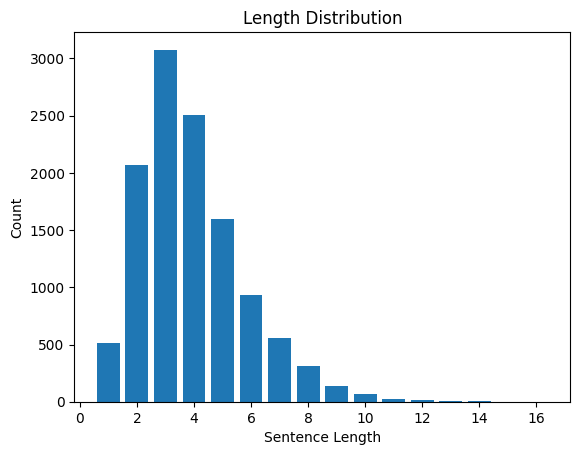

In [11]:
plot_counter(counter_q)

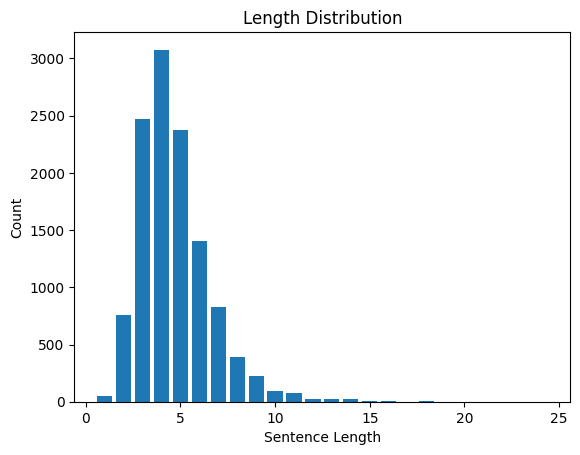

In [12]:
plot_counter(counter_a)

In [13]:
import numpy as np

def calc_stats_from_freq(freq_dict):
    values = np.array(list(freq_dict.keys()), dtype=float)
    counts = np.array(list(freq_dict.values()), dtype=float)

    total = counts.sum()

    mean = np.average(values, weights=counts)

    variance = np.average((values - mean) ** 2, weights=counts)
    std = np.sqrt(variance)

    return mean, std, int(total)


In [14]:
import math

mean, std, total = calc_stats_from_freq(counter_q)
print(f"평균: {mean}")
print(f"표준편차: {std}")
print(f"전체 개수: {total}")

k = 2.5
max_len = math.ceil( mean + k * std )
print(f"max_len: {max_len}")

평균: 3.925230482956948
표준편차: 1.8436727295353255
전체 개수: 11823
max_len: 9


In [15]:
mean, std, total = calc_stats_from_freq(counter_a)
print(f"평균: {mean}")
print(f"표준편차: {std}")
print(f"전체 개수: {total}")

k = 2.5
max_len = math.ceil( mean + k * std )
print(f"max_len: {max_len}")

평균: 4.6850207223209
표준편차: 1.901868478774924
전체 개수: 11823
max_len: 10


#### **데이터 특징**
- 데이터가 누락된 부분은 없음
- 답변 부분에 특수문자로만 이루어진 데이터가 '1개'있긴 하지만, 그냥 무시해도 될 정도인듯
- 중심 구간이 뚜렷함 : 대부분의 문장이 2~5단어에 집중되어 있어 학습이 안정적일 것으로 예상함
- 이상치 비율이 매우 낮음
- 이상치가 극단적이지 않음

#### **결론**
- 공백 기준으로 나눌 시 특이사항 없음. 그대로 진행!

In [16]:
def read_chatbotdata_data(path_to_dataset):
    with open(path_to_dataset, 'r', errors='ignore') as f:
        lines = f.readlines()

    pairs = []
    for line in lines[1:]:
        parts = line.strip().split(",")

        q_text = preprocess_sentence(parts[0])
        a_text = preprocess_sentence(parts[1])
        pairs.append((q_text, a_text))

    return pairs
        

In [17]:
pairs = read_chatbotdata_data(path_to_dataset)

print('전체 샘플 수 :', len(pairs))

전체 샘플 수 : 11823


In [18]:
pairs[0]

('12시 땡 !', '하루가 또 가네요 .')

## **Step 3. SentencePiece 사용하기**

### **병렬 데이터 전처리하기**

In [19]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()

# 이전 수업에서 만들었던 SentencePiece 모델 활용함
sp_model_path = "/home/jjeong3150/work/ex07/"
sp_model_name = "korean_spm_2.model"
sp.Load(sp_model_path + sp_model_name)

True

### **SentencePiece 모델 가져오기**

In [20]:
for i in range(sp.get_piece_size()):
    print(i, sp.id_to_piece(i))

0 <pad>
1 <unk>
2 <s>
3 </s>
4 ▁
5 .
6 을
7 의
8 에
9 이
10 를
11 는
12 가
13 은
14 ,
15 고
16 에서
17 로
18 한
19 ▁“
20 인
21 ”
22 일
23 과
24 )
25 (
26 ▁이
27 으로
28 지
29 와
30 ▁있다
31 도
32 ▁수
33 할
34 다
35 했다
36 ▁밝혔다
37 ▁말했다
38 년
39 하고
40 하는
41 리
42 기
43 ▁있는
44 ▁전
45 스
46 ▁그
47 자
48 며
49 해
50 ▁2
51 ▁그는
52 ▁1
53 만
54 ▁대한
55 된
56 ▁위해
57 월
58 ▁미국
59 ▁전했다
60 ▁3
61 ▁미
62 ▁중
63 ▁한
64 사
65 ▁이번
66 시
67 ▁지난
68 현지시간
69 라
70 어
71 에게
72 나
73 주
74 ▁대해
75 "
76 s
77 게
78 트
79 ▁것으로
80 ▁‘
81 드
82 대
83 명이
84 ▁것
85 ▁것이라고
86 이라고
87 ▁주
88 ▁"
89 르
90 들이
91 ▁4
92 수
93 ▁있다고
94 아
95 하기
96 ▁것을
97 세
98 상
99 서
100 ▁이라크
101 히
102 ▁6
103 부
104 적인
105 ’
106 하지
107 ▁5
108 운
109 치
110 ▁더
111 원
112 ▁그러나
113 들은
114 ▁대통령
115 ▁다른
116 하게
117 명
118 ▁중국
119 적
120 비
121 라고
122 프
123 ▁한편
124 전
125 ▁10
126 소
127 ▁바
128 ▁내
129 던
130 장
131 e
132 성
133 ▁북한
134 ▁후
135 -
136 정
137 명의
138 됐다
139 니
140 미
141 ▁이후
142 했다고
143 ▁한국
144 ▁정부
145 선
146 ▁영국
147 ▁아
148 오
149 크
150 ▁7
151 화
152 마
153 ▁통해
154 면
155 ▁알
156 보
157 ▁등
158 분
159 국
160 ▁많은
161 ▁두
162 ▁

In [21]:
# 예제 문장
sentence = "안녕. 반가워 친구야. 잘 부탁해"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 안녕 . 반가워 친구야 . 잘 부탁해
Tokenized: ['▁안', '녕', '▁', '.', '▁반', '가', '워', '▁친구', '야', '▁', '.', '▁잘', '▁부탁', '해']
Encoded: [255, 7746, 4, 5, 257, 12, 497, 1410, 169, 4, 5, 626, 6392, 49]
Decoded: 안녕 . 반가워 친구야 . 잘 부탁해


#### **Token 기준으로 나눌 시 데이터 확인**

In [22]:

def data_profiling_token(pairs):
    from collections import Counter

    q_token_list = []
    a_token_list = []
    for q_text, a_text in pairs:
        tokens_q = sp.encode(q_text, out_type=str)
        tokens_a = sp.encode(a_text, out_type=str)
        
        q_token_list.append(len(tokens_q))
        a_token_list.append(len(tokens_a))

        
    counter_q = Counter(q_token_list)
    counter_a = Counter(a_token_list)

    return counter_q, counter_a

In [23]:
token_counter_q, token_counter_a = data_profiling_token(pairs)

평균: 8.725365812399561
표준편차: 3.9517437513774736
전체 개수: 11823
max_len: 19


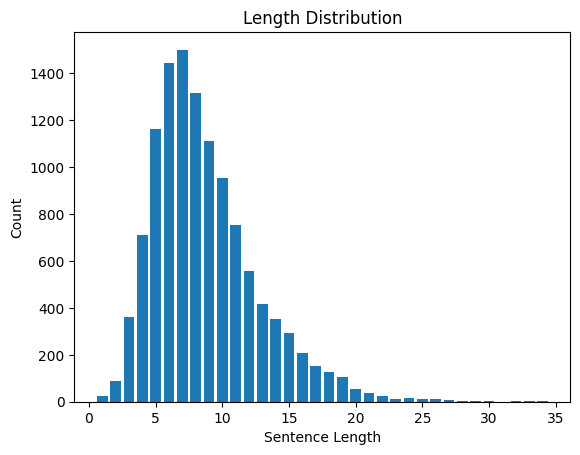

In [24]:
import math

mean, std, total = calc_stats_from_freq(token_counter_q)
print(f"평균: {mean}")
print(f"표준편차: {std}")
print(f"전체 개수: {total}")

k = 2.5
max_len = math.ceil( mean + k * std )
print(f"max_len: {max_len}")


plot_counter(token_counter_q)

평균: 11.075953649665905
표준편차: 3.789966963343621
전체 개수: 11823
max_len: 21


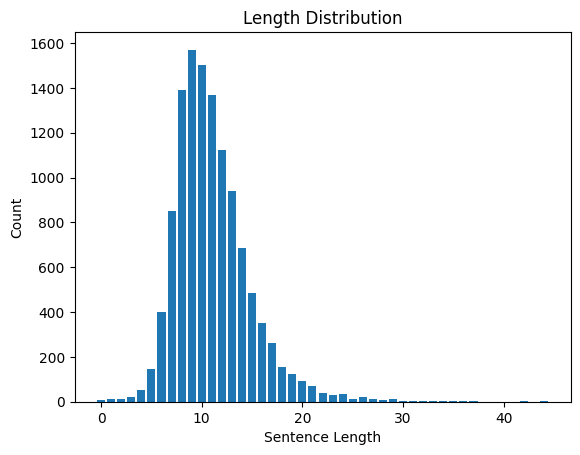

In [25]:
import math

mean, std, total = calc_stats_from_freq(token_counter_a)
print(f"평균: {mean}")
print(f"표준편차: {std}")
print(f"전체 개수: {total}")

k = 2.5
max_len = math.ceil( mean + k * std )
print(f"max_len: {max_len}")

plot_counter(token_counter_a)

#### **결론**
- max 토큰 수 21으로 설정(데이터 99% 이상 커버 가능)

In [26]:
class ChatBotDataset(Dataset):
    def __init__(self, pairs, sp, max_length=21):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            # bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            # eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2
            # ---------------------------------------
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 2  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 3
            # ---------------------------------------

            
            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

In [27]:
dataset = ChatBotDataset(pairs, sp, max_length=21)

In [28]:
for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([21])
tensor([   2,  227,   66,    4,    1,    4, 3881,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0])
12시  ⁇  !
tensor([   2, 1043,   12,  162,    4,   12,  553,  523,    4,    5,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
하루가 또 가네요 .
tensor([1043,   12,  162,    4,   12,  553,  523,    4,    5,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
하루가 또 가네요 .


## **Step 4. 모델 구성하기**

### **Position 인코딩**

In [29]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model  # 임베딩 차원
        self.position = position  # 최대 문장 길이

        self.pos_encoding = self._build_pos_encoding(position, d_model)  # 미리 계산된 위치 벡터 테이블 저장

    def _get_angles(self, position, i, d_model):  # 각도 계산 함수
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):  # 전체 테이블 생성 (모든 위치 × 모든 차원에 대한 PE 테이블 생성)
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1) # 토큰의 위치 번호
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)  # 차원 인덱스 : 임베딩 벡터 안에서 몇 번째 좌표인가

        angle_rads = self._get_angles(pos, i, d_model)  # 각도 계산 / 타입은 float32 실수 텐서
        sines = torch.sin(angle_rads[:, 0::2])  # 0,2,4,6...
        cosines = torch.cos(angle_rads[:, 1::2])  # 1,3,5,7...

        pos_encoding = torch.zeros(position, d_model)  # 위치 임베딩 테이블
        
        # 비어 있는 위치 테이블에 sin 값과 cos 값을 번갈아 끼워 넣는 작업
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        # (position, d_model)짜리 표를, (1, position, d_model)짜리 묶음으로 바꾼다
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

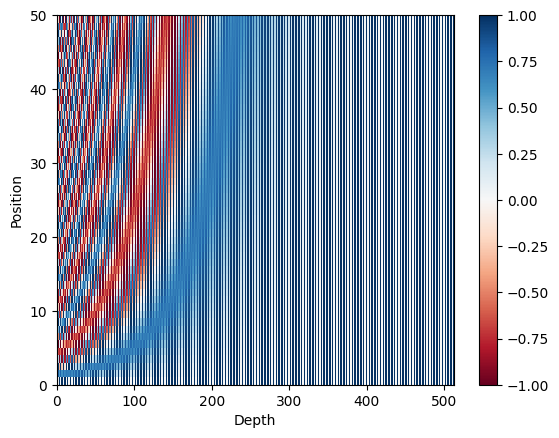

In [30]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Y축 = 단어 위치(순서), X축 = 임베딩 벡터의 차원 번호

### **스케일드 닷 프로덕트 어텐션**

In [31]:
def scaled_dot_product_attention(query, key, value, mask=None):  # Q, K, V로 Attention(Q,K,V) 계산하기

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads  # Attention 공식의 √dₖ
    logits = matmul_qk / math.sqrt(depth)  # math.sqrt(depth) : Attention 학습이 터지지 않게 막는 안전장치

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

### **Multi Head Attention**

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # 헤드 개수 (예: 8)
        self.d_model = d_model  # 입력 임베딩 차원 (예: 512)

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads  # 각 헤드의 차원

        # 파이토치에서 Dense는 nn.Linear로 대응
        # 입력을 Q/K/V로 바꾸는 선형변환(Linear) 3개
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):  # d_model 하나짜리 벡터를 → 여러 개 head용 작은 벡터로 쪼개는 작업
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        # view는 “쪼개는 게 아니라, 메모리를 다른 모양으로 해석해서 보겠다”는 선언
        # 굳이 메모리 관점에서 보는 이유는 ‘속도와 확장성’ 때문
        # 복사가 많아지면 속도 폭락, VRAM 폭
        
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        # permute : 텐서의 축 순서를 바꾸는 함
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


### **룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)**

In [33]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [34]:
x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


In [35]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [36]:
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [37]:
x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


### **인코더**

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


In [39]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

### **디코더**

In [40]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [41]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

### **DataLoader 구성하기**

In [42]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [43]:
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 21])
torch.Size([32, 20])
torch.Size([32, 20])


### **모델 정의 및 학습하기**

In [44]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

### **모델 생성**

In [45]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2     # 인코더/디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

### **손실 함수(Loss function)**

In [46]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

### **커스텀 된 학습률(learning rate)**

In [47]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

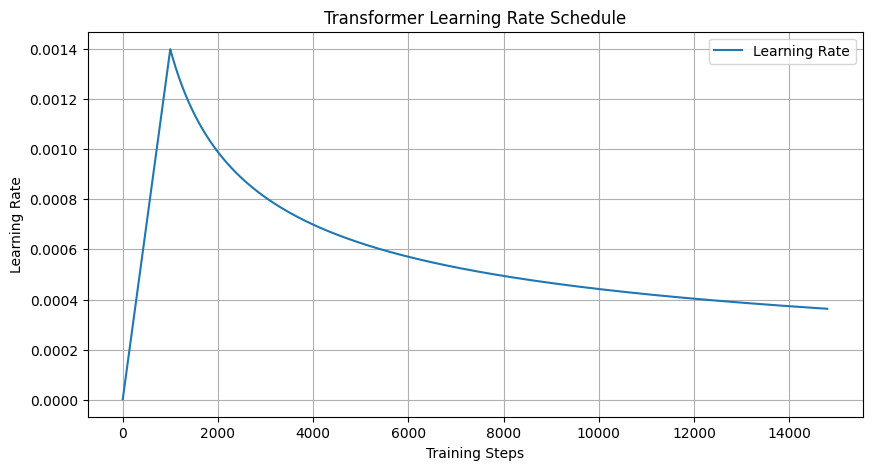

In [48]:
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 1000
# 전체 스텝의 5~10% 정도로 맞춤
# epoch 40으로 가정하면
# 1epoch = 11823 / 32 ≈ 370 (step)
# 370 X 40 ≈ 14,800 (step)
# 14,800 X 0.05 ≈ 740 (step)
# 약 warmup 스텝은 1000 정도로 결정

total_steps = 14800  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


### **모델 컴파일**

In [49]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cuda


### **훈련하기**

In [51]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [52]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [53]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=40,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.2648, Acc: 0.0000
[Epoch 1, Step 100] Loss: 9.2085, Acc: 0.0000
[Epoch 1, Step 200] Loss: 9.1743, Acc: 0.0000
[Epoch 1, Step 300] Loss: 9.0973, Acc: 0.0000
Epoch 1 Completed - Avg Loss: 9.1729, Avg Acc: 0.0001
[Epoch 2, Step 0] Loss: 9.0866, Acc: 0.0000
[Epoch 2, Step 100] Loss: 8.9687, Acc: 0.0000
[Epoch 2, Step 200] Loss: 8.8769, Acc: 0.0000
[Epoch 2, Step 300] Loss: 8.6433, Acc: 0.0090
Epoch 2 Completed - Avg Loss: 8.8587, Avg Acc: 0.0035
[Epoch 3, Step 0] Loss: 8.5690, Acc: 0.0182
[Epoch 3, Step 100] Loss: 8.3651, Acc: 0.1408
[Epoch 3, Step 200] Loss: 8.1752, Acc: 0.2243
[Epoch 3, Step 300] Loss: 7.9155, Acc: 0.2548
Epoch 3 Completed - Avg Loss: 8.1924, Avg Acc: 0.1848
[Epoch 4, Step 0] Loss: 7.7756, Acc: 0.2528
[Epoch 4, Step 100] Loss: 7.4441, Acc: 0.2744
[Epoch 4, Step 200] Loss: 7.4595, Acc: 0.2583
[Epoch 4, Step 300] Loss: 7.0579, Acc: 0.2857
Epoch 4 Completed - Avg Loss: 7.4177, Avg Acc: 0.2700
[Epoch 5, Step 0] Loss: 7.1572, Acc: 0.2793
[Epoch 5, St

## **Step 5. 모델 평가하기**

In [54]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = preprocess_sentence(sentence)
    print(sentence)
    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    print(enc_input_ids)
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [55]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [56]:
sentence = '여행가고싶어'
sentence_generation(model, sentence, sp, device)

여행가고싶어
[2, 885, 12, 15, 7980, 70, 3]
입력 : 여행가고싶어
출력 : .


'.'

In [57]:
sentence = '친구야 반갑다'
sentence_generation(model, sentence, sp, device)

친구야 반갑다
[2, 1410, 169, 257, 2757, 34, 3]
입력 : 친구야 반갑다
출력 : .


'.'

### **1차 모델 결과**
- 정확도가 너무 낮음(최종 35.76%)
- 작은 값이지만 평균 loss가 지속적으로 줄어드는 걸 보니 과적합 문제는 아닌듯
- learning rate scheduler로 인해 학습률이 너무 작아져서 발생하는 현상처럼 보임

### **해결방안**
- optimizer 생성 시 lr 값을 1.0으로 정의하고 Loss 및 정확도 관찰해보기

### **모델 생성 2**

In [58]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2     # 인코더/디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)

# 모델 생성
model_a = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model_a)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

In [59]:
# Optimizer 정의
optimizer_a = optim.Adam(model_a.parameters(), betas=(0.9, 0.98), eps=1e-9, lr=1.0)

# Scheduler 정의
scheduler_a = lr_scheduler.LambdaLR(optimizer_a, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps))

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_a = model_a.to(device)

cuda


### **훈련하기**

In [61]:
%%time

train(
    model=model_a,
    dataloader=dataloader,
    optimizer=optimizer_a,
    loss_function=loss_function,
    scheduler=scheduler_a,
    num_epochs=40,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.1114, Acc: 0.0000
[Epoch 1, Step 100] Loss: 4.7545, Acc: 0.3546
[Epoch 1, Step 200] Loss: 3.7567, Acc: 0.4265
[Epoch 1, Step 300] Loss: 3.2299, Acc: 0.4753
Epoch 1 Completed - Avg Loss: 4.7163, Avg Acc: 0.3576
[Epoch 2, Step 0] Loss: 3.0676, Acc: 0.5061
[Epoch 2, Step 100] Loss: 2.7791, Acc: 0.5027
[Epoch 2, Step 200] Loss: 2.8950, Acc: 0.4915
[Epoch 2, Step 300] Loss: 2.5807, Acc: 0.5210
Epoch 2 Completed - Avg Loss: 2.9507, Avg Acc: 0.4843
[Epoch 3, Step 0] Loss: 2.5411, Acc: 0.5154
[Epoch 3, Step 100] Loss: 2.8392, Acc: 0.4593
[Epoch 3, Step 200] Loss: 2.6565, Acc: 0.4913
[Epoch 3, Step 300] Loss: 2.6658, Acc: 0.4959
Epoch 3 Completed - Avg Loss: 2.5655, Avg Acc: 0.5167
[Epoch 4, Step 0] Loss: 2.2291, Acc: 0.5385
[Epoch 4, Step 100] Loss: 2.1696, Acc: 0.5586
[Epoch 4, Step 200] Loss: 2.2510, Acc: 0.5818
[Epoch 4, Step 300] Loss: 2.2229, Acc: 0.5537
Epoch 4 Completed - Avg Loss: 2.2904, Avg Acc: 0.5466
[Epoch 5, Step 0] Loss: 1.9971, Acc: 0.5612
[Epoch 5, St

In [71]:
sentence = '여행이나 갈까'
sentence_generation(model_a, sentence, sp, device)

여행이나 갈까
[2, 885, 408, 1596, 2240, 3]
입력 : 여행이나 갈까
출력 : 좋은 생각이에요 .


'좋은 생각이에요 .'

In [75]:
sentence = '짜장면 먹고싶네'
sentence_generation(model_a, sentence, sp, device)

짜장면 먹고싶네
[2, 4, 4755, 130, 154, 4, 7975, 15, 7980, 553, 3]
입력 : 짜장면 먹고싶네
출력 : 생각만 해도 군침이 도네요 .


'생각만 해도 군침이 도네요 .'

In [78]:
sentence = '책 추천좀?'
sentence_generation(model_a, sentence, sp, device)

책 추천좀 ?
[2, 1730, 6974, 7763, 4, 677, 3]
입력 : 책 추천좀?
출력 : 도서관 다녀오세요 .


'도서관 다녀오세요 .'

In [79]:
sentence = '사과의 색깔은?'
sentence_generation(model_a, sentence, sp, device)

사과의 색깔은 ?
[2, 1574, 7, 3435, 7923, 13, 4, 677, 3]
입력 : 사과의 색깔은?
출력 : 보고싶다고 연락은 .


'보고싶다고 연락은 .'

In [87]:
sentence = '콜라와 사이다 중 뭐를 마실까'
sentence_generation(model_a, sentence, sp, device)

콜라와 사이다 중 뭐를 마실까
[2, 1602, 69, 29, 690, 34, 62, 4, 7826, 10, 243, 307, 2240, 3]
입력 : 콜라와 사이다 중 뭐를 마실까
출력 : 완전히 똑같은 것도 용기내세요 .


'완전히 똑같은 것도 용기내세요 .'

In [81]:
sentence = '으아아아'
sentence_generation(model_a, sentence, sp, device)

으아아아
[2, 4, 2251, 94, 94, 94, 3]
입력 : 으아아아
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

### **2차 모델 결과**
- 정확도 대폭 상승(최종 96.63.%)
- 평균 Loss가 튀는 경우 없는 것 보니 epoch을 더 늘려도 될듯
- 답변이 다소 어색하긴 하나 맥락은 대강 맞는 것으로 보임
- 학습 데이터양이 많지 않았던 것 같음

## **회고**

- Data가 바뀌어서 Dataset을 만들기 위한 과정이 크게 바뀌었음
- 1차 모델의 경우 정확도가 너무 낮아서 2차 모델에서 learning rate를 늘려줬더니 정확도가 크게 개선됨
- 데이터 양이 약 11,000건 정도로 많지 않았던 것 같음. 만약 데이터 양이 많았다면 더 좋은 챗봇을 만들 수 있지 않았을까 생각함